In [ ]:
import os
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
train_data = datasets.MNIST(root = "data",
                                    train = True,
                                    download = True,
                                    transform = ToTensor(),
                                    target_transform = None
                                    )

test_data = datasets.MNIST(root = "data",
                                   train = False,
                                   download = True,
                                   transform = ToTensor(),
                                   )

100%|██████████| 9912422/9912422 [00:00<00:00, 192041826.96it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 16347597.01it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 175014966.00it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23346236.24it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


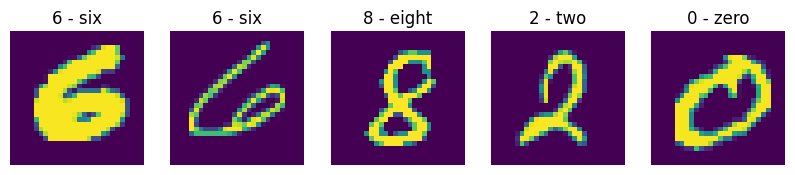

In [ ]:
class_names = train_data.classes
torch.manual_seed(42)

print(class_names)
fig = plt.figure(figsize = (10,50))
cols = 5

for i in range(1, cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(1, cols, i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class MNISTModel(nn.Module):
  def __init__(self, input_shape : int, hidden_units : int, output_shape : int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*7*7,
                  out_features = output_shape)
    )

  def forward(self, x : torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model = MNISTModel(input_shape = 1,
                    hidden_units = 10,
                    output_shape = len(class_names)).to(device)
model

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                                    lr = 0.1)
acc_fn = Accuracy(task = "multiclass", num_classes = 10).to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 29.4 MB/s eta 0:00:00


In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
  train_loss, train_acc = 0,0
  model.to(device)

  for batch , (X, y) in enumerate(data_loader):
    X , y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += acc_fn(y_pred.argmax(dim = 1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train accuracy : {train_acc:.2f}%\n")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              acc_fn,
              device: torch.device = device):
  test_loss, test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += acc_fn(y_pred.argmax(dim = 1),y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_model_Fashion = timer()

from tqdm.auto import tqdm
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(data_loader = train_dataloader,
             model = model,
             loss_fn = loss_fn,
             optimizer = optimizer,
             acc_fn = acc_fn,
             device = device
             )

  test_step(data_loader = test_dataloader,
            model = model,
            loss_fn = loss_fn,
            acc_fn = acc_fn,
            device = device
            )

train_time_end_model_Fashion = timer()

def print_train_time(start : float, end : float, device : torch.device = None):
  total_time = end - start
  print(f"Training time  {device} : {total_time:.3f} seconds")
  return total_time

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss : 0.33213 | Train accuracy : 0.89%

Test loss: 0.07257 | Test accuracy: 0.98%

Epoch: 1
--------
Train loss : 0.07942 | Train accuracy : 0.98%

Test loss: 0.06755 | Test accuracy: 0.98%

Epoch: 2
--------
Train loss : 0.06264 | Train accuracy : 0.98%

Test loss: 0.05406 | Test accuracy: 0.98%

Epoch: 3
--------
Train loss : 0.05373 | Train accuracy : 0.98%

Test loss: 0.06162 | Test accuracy: 0.98%

Epoch: 4
--------
Train loss : 0.04864 | Train accuracy : 0.98%

Test loss: 0.04590 | Test accuracy: 0.98%



In [ ]:
model_pred_logits = model(test_data[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
model_pred_probs = torch.softmax(model_pred_logits, dim=1)
model_pred_label = torch.argmax(model_pred_probs, dim=1)
model_pred_label

tensor([7], device='cuda:0')

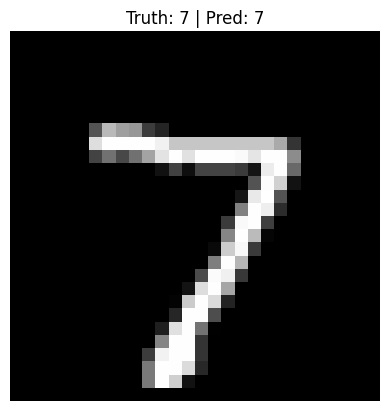

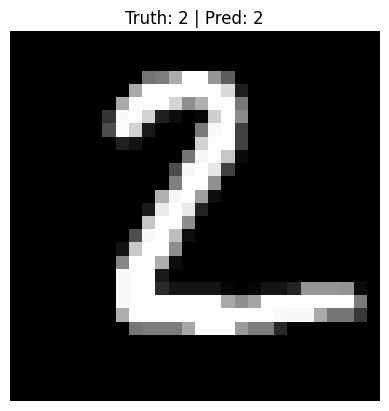

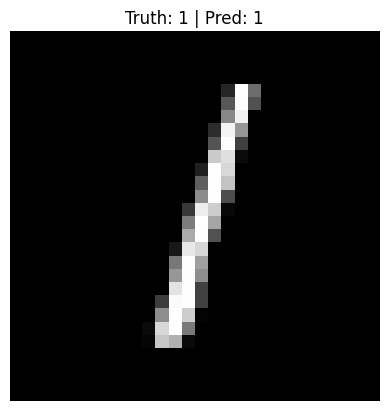

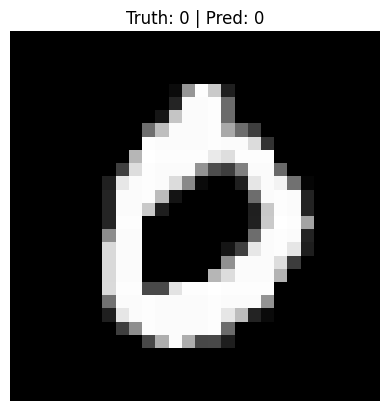

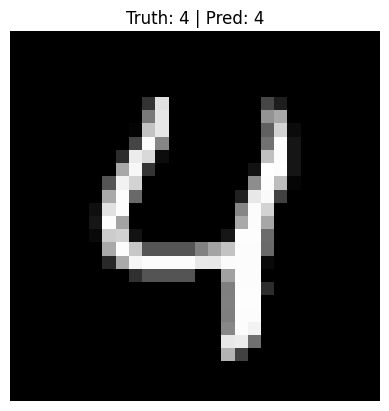

In [ ]:
nums = 5
for i in range(nums):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  model_pred_logits = model(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  # Plot the image and prediction
  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}")
  plt.axis(False)

In [ ]:
!pip install -q torchmetrics -U mlxtend
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")


model.eval()
y_preds = []

with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    X, y = X.to(device), y.to(device)
    y_pred_logits = model(X)
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    y_preds.append(y_pred_labels)

  y_preds=torch.cat(y_preds).cpu()

len(y_preds)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.0 MB/s eta 0:00:00
mlxtend version: 0.22.0


0it [00:00, ?it/s]

10000

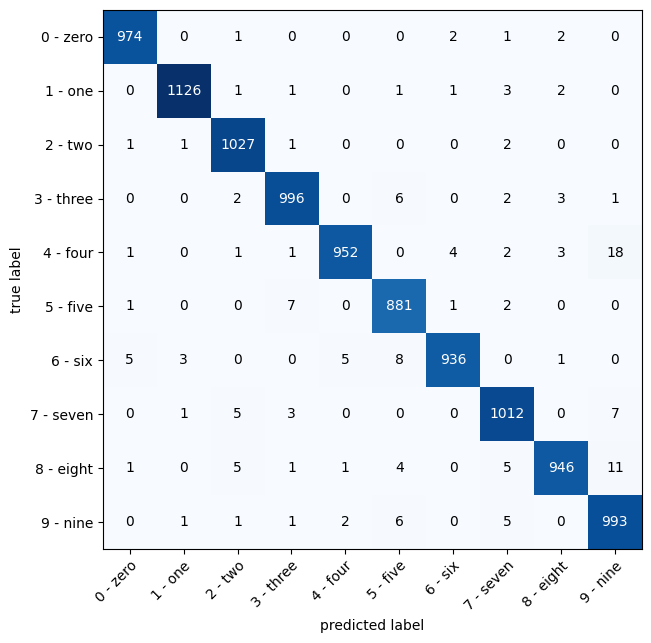

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)